In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as torch_datasets



from adabelief_pytorch import AdaBelief

from models import LAVAE, torch_dataloader, torch_latent_dataloader
import utils as ut

# Auto reload Libraries
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set Seeds
torch.manual_seed(0)
np.random.seed(0)

LATENT_DIM = 2
IMAGE_SIZE = 28
EPOCHS = 50

lambda_KL = 10
lambda_L2 = 1

/var/folders/n7/b5dt_rrd5dv7z7wz4pl21bzc0000gn/T/ipykernel_4730/2753218961.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Data
train_loader, test_loader = ut.MNIST_data(class_filer=2,aug=True,Plot=False)
print('Train/Test Size: {}/{}'.format(len(train_loader.dataset),len(test_loader.dataset)))

# Model
model = LAVAE(latent_dim=LATENT_DIM,image_dim=IMAGE_SIZE,latent_linear=True).to(device)
# Print Number of Parameters
print('Model Parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# VAE Optimizer
parameters = list(model.encoder.parameters()) + list(model.decoder.parameters())
optimizer_VAE = AdaBelief(parameters,lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = False, rectify = False,print_change_log = False)

# Augmentation Optimizer
optimizer_AUG = AdaBelief([model.Laug],lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = False, rectify = False,print_change_log = False)

Train/Test Size: 11916/2064
Model Parameters: 308361


In [ ]:
# Store Losses
losses = {'KLD':[], 
          'Reconstruction':[],
          'Total':[]}

# Train
for epoch in range(1,EPOCHS+1):
    model.train()

    # Losses
    losses['KLD'].append(0)
    losses['Reconstruction'].append(0)
    losses['Total'].append(0)

    for idx, (x,label) in enumerate(train_loader):

        # x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]).to(device)
        x = x.to(device)
        optimizer_VAE.zero_grad()

        x_hat, mu, logvar = model(x)

        loss_KLD = ut.vae_KLD(mu,logvar)
        loss_recon = ut.vae_recon_loss(x, x_hat,image_size=IMAGE_SIZE)
        loss = lambda_KL * loss_KLD + lambda_L2 * loss_recon
        loss = loss_KLD + loss_recon
        loss.backward()
        optimizer_VAE.step()

        losses['KLD'][-1] += loss_KLD.item()
        losses['Reconstruction'][-1] += loss_recon.item()
        losses['Total'][-1] += loss.item()

    # Divide lossed by number of batches
    losses['KLD'][-1] /= len(train_loader)
    losses['Reconstruction'][-1] /= len(train_loader)
    losses['Total'][-1] /= len(train_loader)

    # Test
    test_loss = ut.test(model, test_loader, device,image_size=IMAGE_SIZE)
        
    if epoch % 5 == 0:
        print('Epoch: {}/{},'.format(epoch, EPOCHS),
                'Total Loss: {:.4f},'.format(losses['Total'][-1]),
                'KLD: {:.4f}'.format(losses['KLD'][-1]),
                'Reconstruction: {:.4f}'.format(losses['Reconstruction'][-1]),
                'Test Loss: {:.8f}'.format(test_loss),
                )

        # Save Model
        torch.save(model.state_dict(), 'checkpoints/MNIST_linear/LAVAE_VAE_{}.pt'.format(epoch))



plt.plot(losses['Total'], label='Total')
plt.plot(losses['KLD'], label='KLD')
plt.plot(losses['Reconstruction'], label='Reconstruction')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Tran and Test Losses', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend()

In [3]:
# Load model
model.load_state_dict(torch.load('checkpoints/MNIST_linear/LAVAE_VAE_50.pt'))

<All keys matched successfully>

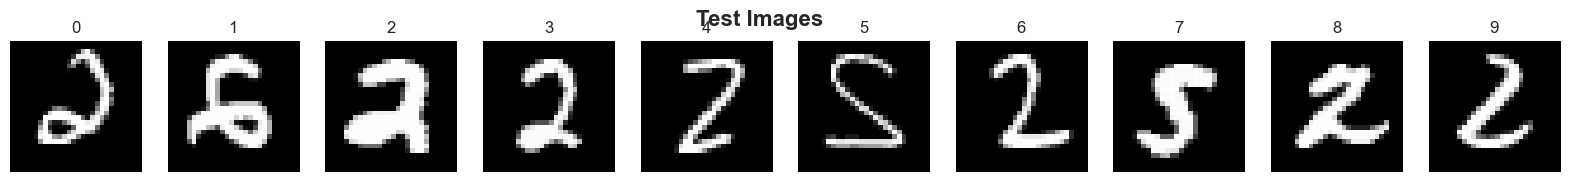

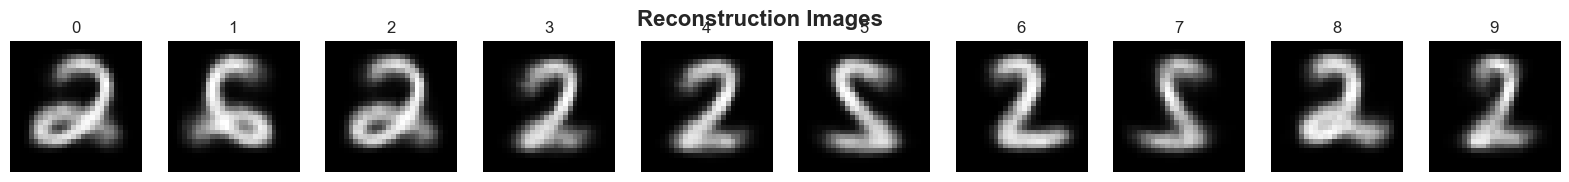

In [4]:
# Plot Test Results
images = next(iter(test_loader))[0][0:10,:,:]

with torch.no_grad():
    model.eval()
    x_hat,z,_ = model(images.reshape(10,1,IMAGE_SIZE,IMAGE_SIZE).to(device).type(torch.float32))

ut.plot_images(images.detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Test Images')
ut.plot_images(x_hat.detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Reconstruction Images')

## Latent Augment Train

Train/Test Size: 5958/1032


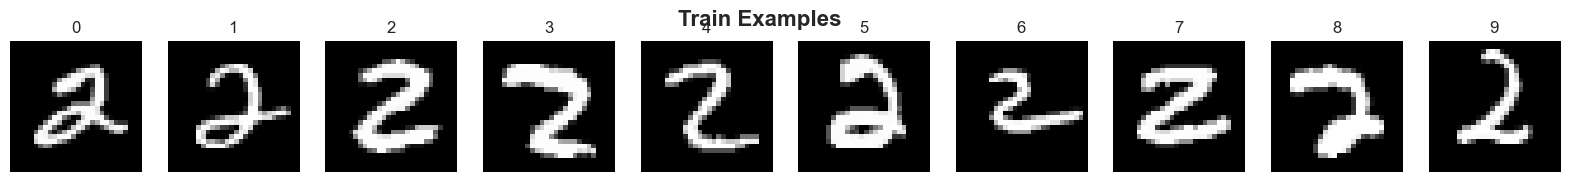

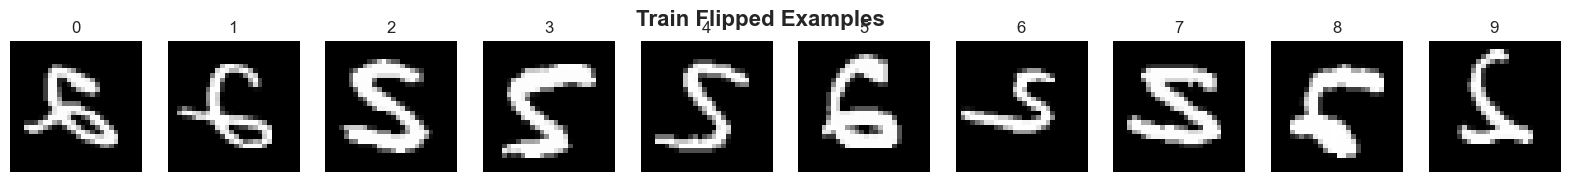

In [5]:
# Data
train_loader, test_loader = ut.MNIST_data(class_filer=2,aug=False)
print('Train/Test Size: {}/{}'.format(len(train_loader.dataset),len(test_loader.dataset)))

In [9]:
# Train Variables
EPOCHS = 20

# Store Losses
losses = []

# Loss Reconstruction
MSE_latent = torch.nn.MSELoss()

# Train
for epoch in range(1,EPOCHS+1):

    # Losses
    losses.append(0)

    for idx, (x,x_flip) in enumerate(train_loader):

        x = x.to(device)
        x_flip = x_flip.to(device)

        with torch.no_grad():
            model.eval()
            _,z,_ = model(x)
            _,z_flip,_ = model(x_flip)

        model.train()

        optimizer_AUG.zero_grad()
        z_hat_flip = z @ model.Laug

        

        loss = MSE_latent(z_hat_flip, z_flip)
        loss.backward()
        optimizer_AUG.step()

        losses[-1] += loss.item()

    # Divide lossed by number of batches
    losses[-1] /= len(train_loader)

    # Test
    test_loss = ut.test_flip(model, test_loader, device,image_size=IMAGE_SIZE)
        
    if epoch % 5 == 0:
        print('Epoch: {}/{},'.format(epoch, EPOCHS),
                'Loss: {:.4f},'.format(losses[-1]),
                'Test Loss: {:.8f}'.format(test_loss),
                )

        # Save Model
        torch.save(model.state_dict(), 'checkpoints/MNIST_linear/LAVAE_{}.pt'.format(epoch))

Epoch: 5/20, Loss: 0.1370, Test Loss: 267.45781146
Epoch: 10/20, Loss: 0.1362, Test Loss: 267.45781146
Epoch: 15/20, Loss: 0.1362, Test Loss: 267.45781146
Epoch: 20/20, Loss: 0.1362, Test Loss: 267.45781146


### Laug Test Results

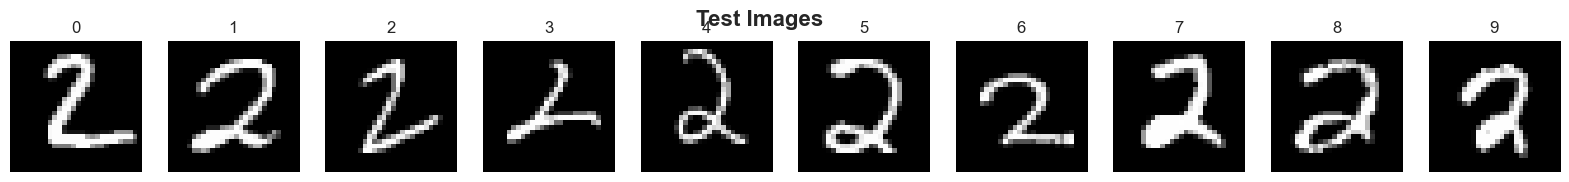

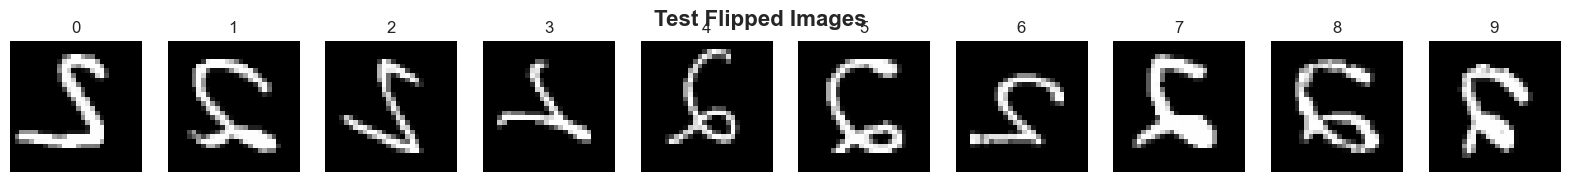

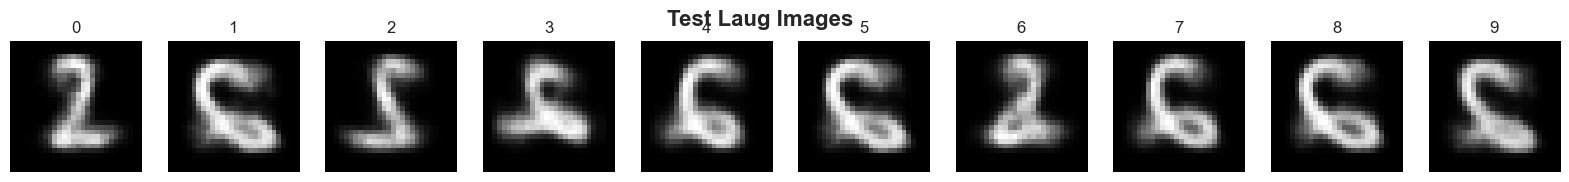

In [15]:
# Plot a few examples of latent transformer

# Data
images = next(iter(test_loader))[0][0:10,:,:]

with torch.no_grad():
    model.eval()
    x_hat,z,_ = model(images.reshape(10,1,IMAGE_SIZE,IMAGE_SIZE).to(device).type(torch.float32))
    z_hat_flip = z @ model.Laug
    z_hat_hat = z_hat_flip @ model.Laug.T
    x_hat_flip = model.decoder(z_hat_flip)

ut.plot_images(images.detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Test Images')
ut.plot_images(next(iter(test_loader))[1][0:10,:,:].detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Test Flipped Images')
ut.plot_images(x_hat_flip.detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Test Laug Images')

### Distance Metric

In [17]:
images = next(iter(test_loader))[0]

with torch.no_grad():
    model.eval()
    x_hat,z,_ = model(images.reshape(images.shape[0],1,IMAGE_SIZE,IMAGE_SIZE).to(device).type(torch.float32))
    z_hat_flip = z @ model.Laug
    # z_hat_hat = model.Laug(z_hat_flip)
    x_hat_flip = model.decoder(z_hat_flip)

In [18]:
train_size  = train_loader.dataset.flipped_data.shape[0]
test_size = test_loader.dataset.flipped_data.shape[0]
# MSE loss
MSE = torch.nn.MSELoss()

trains_distances = []
test_distances = []
for test_image in x_hat_flip:

    # Sample train and test images
    train_idxs = np.random.choice(range(train_size),32,replace=False)
    test_idxs = np.random.choice(range(test_size),32,replace=False)

    train_compare = torch.from_numpy(train_loader.dataset.flipped_data[test_idxs]).type(torch.float32)
    test_compare = torch.from_numpy(test_loader.dataset.flipped_data[test_idxs]).type(torch.float32)

    trains_distances.append(MSE(test_image.repeat(32,1,1),train_compare).item())
    test_distances.append(MSE(test_image.repeat(32,1,1),test_compare).item())

Text(0.5, 1.0, 'MSE Laug Flipped vs Train/Test Flipped\nRandom 32 Samples of Each Per Image')

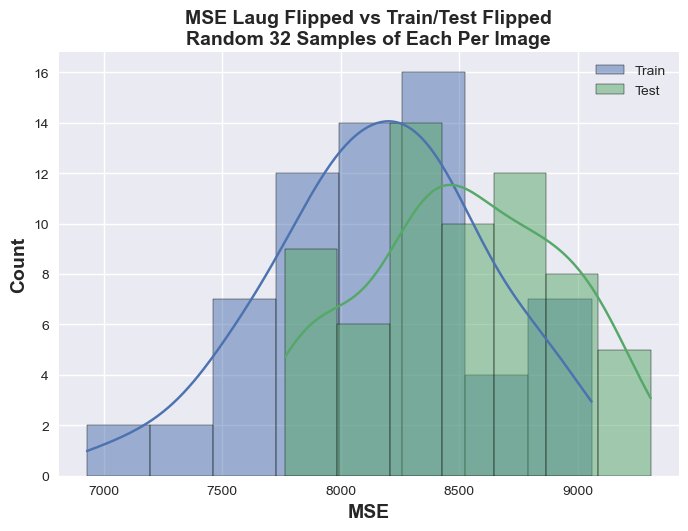

In [19]:
import seaborn as sns

sns.histplot(trains_distances, label='Train',kde=True)
sns.histplot(test_distances, label='Test',kde=True)
plt.legend()
plt.xlabel('MSE', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('MSE Laug Flipped vs Train/Test Flipped\nRandom 32 Samples of Each Per Image', fontsize=14, fontweight='bold')